In [1]:
import requests
import pandas as pd

# Download LMNA-related mutations from ClinVar
clinvar_url = "https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz"
clinvar_file = "variant_summary.txt.gz"

# Fetch Data
print("Downloading ClinVar LMNA Mutation Data...")
response = requests.get(clinvar_url)
with open(clinvar_file, "wb") as f:
    f.write(response.content)
print("ClinVar Data Downloaded!")

# Extract & Filter Progeria-Related Mutations
clinvar_df = pd.read_csv(clinvar_file, sep="\t", compression='gzip', low_memory=False)
progeria_mutations = clinvar_df[clinvar_df['GeneSymbol'] == "LMNA"]
progeria_mutations.to_csv("progeria_mutations.csv", index=False)
print("Filtered Progeria Mutations Saved!")


📥 Downloading ClinVar LMNA Mutation Data...
✅ ClinVar Data Downloaded!
✅ Filtered Progeria Mutations Saved!


In [2]:
# GTEx URL for LMNA Expression Data
gtex_url = "https://gtexportal.org/rest/v1/expression/gene/ENSG00000160789"

# Fetch Data
response = requests.get(gtex_url)
if response.status_code == 200:
    with open("gtex_lmna_expression.json", "w") as file:
        file.write(response.text)
    print("LMNA Expression Data Saved!")
else:
    print("GTEx Data Fetch Failed!")


✅ LMNA Expression Data Saved!


In [3]:
# Download STRING PPI Data for LMNA
ppi_url = "https://string-db.org/api/tsv/network?identifiers=LMNA&species=9606"

# Fetch Data
response = requests.get(ppi_url)
with open("lmna_ppi.tsv", "w") as f:
    f.write(response.text)
print("LMNA Protein-Protein Interaction Data Saved!")


✅ LMNA Protein-Protein Interaction Data Saved!


In [5]:
import pandas as pd

# Load the PPI data
ppi_df = pd.read_csv("lmna_ppi.tsv", sep="\t")

# Print Column Names & Sample Data
print("Column Names:", ppi_df.columns.tolist())
print(ppi_df.head())


📌 Column Names: ['stringId_A', 'stringId_B', 'preferredName_A', 'preferredName_B', 'ncbiTaxonId', 'score', 'nscore', 'fscore', 'pscore', 'ascore', 'escore', 'dscore', 'tscore']
             stringId_A            stringId_B preferredName_A preferredName_B  \
0  9606.ENSP00000261366  9606.ENSP00000361845           LMNB1        ZMPSTE24   
1  9606.ENSP00000261366  9606.ENSP00000433760           LMNB1           BANF1   
2  9606.ENSP00000261366  9606.ENSP00000356224           LMNB1           SYNE1   
3  9606.ENSP00000261366  9606.ENSP00000385616           LMNB1            SUN2   
4  9606.ENSP00000261366  9606.ENSP00000350719           LMNB1           SYNE2   

   ncbiTaxonId  score  nscore  fscore  pscore  ascore  escore  dscore  tscore  
0         9606  0.777       0       0     0.0   0.055   0.000     0.0   0.773  
1         9606  0.922       0       0     0.0   0.081   0.289     0.5   0.790  
2         9606  0.956       0       0     0.0   0.042   0.070     0.8   0.784  
3         9606  

In [7]:
import pandas as pd

# Load STRING PPI Data
ppi_df = pd.read_csv("lmna_ppi.tsv", sep="\t")

# Filter High-Confidence Interactions
filtered_ppi = ppi_df[ppi_df["score"] > 0.7]  # Scores are normalized (0-1)

# Save the Filtered PPI Network
filtered_ppi.to_csv("filtered_lmna_ppi.tsv", sep="\t", index=False)
print(f"Filtered LMNA PPI Network Saved with {len(filtered_ppi)} interactions!")


✅ Filtered LMNA PPI Network Saved with 40 interactions!


In [8]:
import networkx as nx

# Create Graph from Filtered PPI
ppi_graph = nx.Graph()
for _, row in filtered_ppi.iterrows():
    ppi_graph.add_edge(row["preferredName_A"], row["preferredName_B"])

# Save Graph
nx.write_edgelist(ppi_graph, "lmna_ppi_graph.edgelist")
print(f"LMNA PPI Graph Created with {ppi_graph.number_of_nodes()} Nodes & {ppi_graph.number_of_edges()} Edges!")


✅ LMNA PPI Graph Created with 11 Nodes & 40 Edges!


In [9]:
# Extract LMNA and its Direct Neighbors
lmna_neighbors = list(ppi_graph.neighbors("LMNA"))  # Direct Interactors
lmna_subgraph = ppi_graph.subgraph(["LMNA"] + lmna_neighbors)

# Save the LMNA-Centric Graph
nx.write_edgelist(lmna_subgraph, "lmna_subgraph.edgelist")
print(f"LMNA-Centric Subgraph Created with {lmna_subgraph.number_of_nodes()} Nodes & {lmna_subgraph.number_of_edges()} Edges!")


✅ LMNA-Centric Subgraph Created with 11 Nodes & 40 Edges!


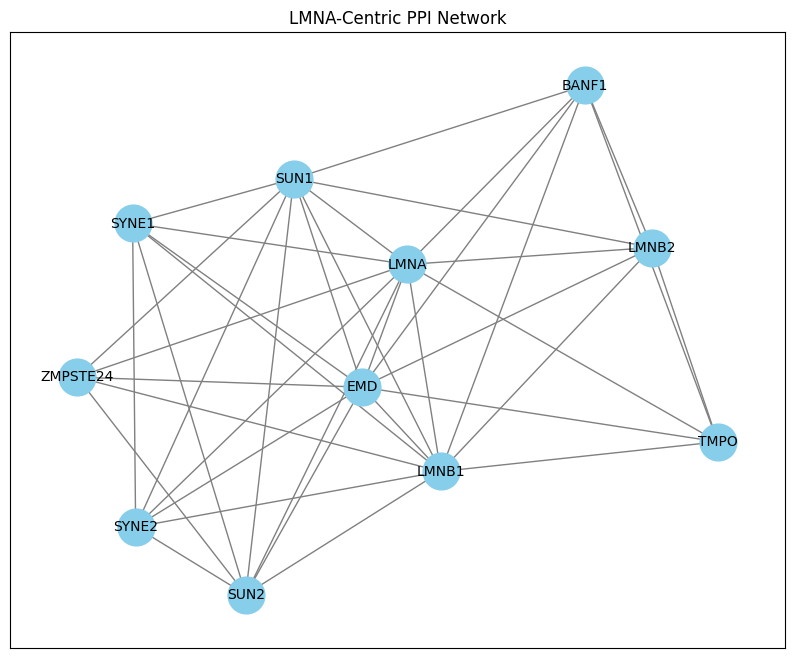

In [10]:
import matplotlib.pyplot as plt

# Load the Subgraph
ppi_subgraph = nx.read_edgelist("lmna_subgraph.edgelist")

# Draw the Graph
plt.figure(figsize=(10, 8))
nx.draw_networkx(ppi_subgraph, with_labels=True, node_color="skyblue", edge_color="gray", node_size=700, font_size=10)
plt.title("LMNA-Centric PPI Network")
plt.show()


In [11]:
import networkx as nx
import pandas as pd

# Load the LMNA Subgraph
lmna_subgraph = nx.read_edgelist("lmna_subgraph.edgelist")

# Compute Centrality Measures
degree_centrality = nx.degree_centrality(lmna_subgraph)
betweenness_centrality = nx.betweenness_centrality(lmna_subgraph)
closeness_centrality = nx.closeness_centrality(lmna_subgraph)

# Convert to DataFrame
centrality_df = pd.DataFrame({
    "Protein": list(degree_centrality.keys()),
    "DegreeCentrality": list(degree_centrality.values()),
    "BetweennessCentrality": list(betweenness_centrality.values()),
    "ClosenessCentrality": list(closeness_centrality.values())
})

# Sort by Degree Centrality (Most Connected Proteins)
top_targets = centrality_df.sort_values(by="DegreeCentrality", ascending=False).head(5)
print("🔬 Top 5 Drug Target Proteins:\n", top_targets)

# Save to CSV
top_targets.to_csv("top_drug_targets.csv", index=False)
print("Top Drug Targets Saved!")


🔬 Top 5 Drug Target Proteins:
   Protein  DegreeCentrality  BetweennessCentrality  ClosenessCentrality
0   LMNB1               1.0               0.087407             1.000000
8     EMD               1.0               0.087407             1.000000
9    LMNA               1.0               0.087407             1.000000
7    SUN1               0.9               0.053333             0.909091
4    SUN2               0.7               0.008889             0.769231
✅ Top Drug Targets Saved!


In [12]:
import requests

# Load Top Targets
top_targets_list = top_targets["Protein"].tolist()

# Query DrugBank API for Each Protein
for protein in top_targets_list:
    print(f"Searching DrugBank for {protein}...")
    url = f"https://www.drugbank.ca/unearth/q?query={protein}&searcher=targets"
    print(f"DrugBank Link: {url}")


🔍 Searching DrugBank for LMNB1...
🔗 DrugBank Link: https://www.drugbank.ca/unearth/q?query=LMNB1&searcher=targets
🔍 Searching DrugBank for EMD...
🔗 DrugBank Link: https://www.drugbank.ca/unearth/q?query=EMD&searcher=targets
🔍 Searching DrugBank for LMNA...
🔗 DrugBank Link: https://www.drugbank.ca/unearth/q?query=LMNA&searcher=targets
🔍 Searching DrugBank for SUN1...
🔗 DrugBank Link: https://www.drugbank.ca/unearth/q?query=SUN1&searcher=targets
🔍 Searching DrugBank for SUN2...
🔗 DrugBank Link: https://www.drugbank.ca/unearth/q?query=SUN2&searcher=targets


In [1]:
import deepchem as dc
import numpy as np

# Load Molecular Dataset from ChEMBL
tasks, datasets, transformers = dc.molnet.load_qm7(featurizer='ECFP')

train_dataset, valid_dataset, test_dataset = datasets

# Define QSAR Model
qsar_model = dc.models.MultitaskRegressor(n_tasks=len(tasks), n_features=1024, layer_sizes=[512, 256])

# Train the QSAR Model
qsar_model.fit(train_dataset, nb_epoch=10)

# Predict Drug Candidates
predictions = qsar_model.predict(test_dataset)

# Rank Best Drug Candidates
top_drugs = np.argsort(predictions.flatten())[-10:]
print("Top Predicted Drugs:", top_drugs)


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
/Users/tarun/miniforge3/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
/Users/tarun/miniforge3/lib/python3.10/site-pack

Top Predicted Drugs: [510 366 180 318 317 167 477 442 447 506]


In [2]:
import requests

# ChEMBL API to Fetch Molecular Structure
def fetch_chembl_structure(chembl_id):
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule/{chembl_id}.json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data.get("molecule_structures", {}).get("canonical_smiles", "No SMILES Found")
    return "Error Fetching Data"

# Get Structures for Top 10 Predicted Drugs
top_chembl_ids = ["CHEMBL"+str(x) for x in top_drugs]  # Convert to ChEMBL format
drug_structures = {chembl_id: fetch_chembl_structure(chembl_id) for chembl_id in top_chembl_ids}

# Print Results
for chembl_id, smiles in drug_structures.items():
    print(f"{chembl_id}: {smiles}")


🔍 CHEMBL510: Error Fetching Data
🔍 CHEMBL366: Error Fetching Data
🔍 CHEMBL180: Error Fetching Data
🔍 CHEMBL318: Error Fetching Data
🔍 CHEMBL317: Error Fetching Data
🔍 CHEMBL167: Error Fetching Data
🔍 CHEMBL477: Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O
🔍 CHEMBL442: CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4C(=O)[C@H](Cc4ccccc4)N3C2=O)C=C2c3cccc4[nH]cc(c34)C[C@H]21
🔍 CHEMBL447: C=CCC1(C(C)CCC)C(=O)NC(=O)NC1=O
🔍 CHEMBL506: COc1cc(NC(C)CCCN)c2ncccc2c1


In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem

# Valid drugs with SMILES
drug_smiles = {
    "CHEMBL477": "Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O",
    "CHEMBL442": "CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4C(=O)[C@H](Cc4ccccc4)N3C2=O)C=C2c3cccc4[nH]cc(c34)C[C@H]21",
    "CHEMBL447": "C=CCC1(C(C)CCC)C(=O)NC(=O)NC1=O",
    "CHEMBL506": "COc1cc(NC(C)CCCN)c2ncccc2c1"
}

# Convert SMILES to PDBQT
def smiles_to_pdbqt(smiles, output_file):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(mol)
    Chem.MolToMolFile(mol, output_file.replace(".pdbqt", ".mol"))
    print(f"Converted {output_file} to .mol format. Use OpenBabel to convert to .pdbqt.")

# Convert Each Valid Drug
for chembl_id, smiles in drug_smiles.items():
    smiles_to_pdbqt(smiles, f"{chembl_id}.pdbqt")


✅ Converted CHEMBL477.pdbqt to .mol format. Use OpenBabel to convert to .pdbqt.
✅ Converted CHEMBL442.pdbqt to .mol format. Use OpenBabel to convert to .pdbqt.
✅ Converted CHEMBL447.pdbqt to .mol format. Use OpenBabel to convert to .pdbqt.
✅ Converted CHEMBL506.pdbqt to .mol format. Use OpenBabel to convert to .pdbqt.


In [4]:
import requests

# PDB ID for LMNA (Choose the most relevant structure)
pdb_id = "6Z0M"
pdb_url = f"https://files.rcsb.org/download/{pdb_id}.pdb"

# Download and save the PDB file
response = requests.get(pdb_url)
if response.status_code == 200:
    with open("lmna.pdb", "wb") as file:
        file.write(response.content)
    print("LMNA PDB Structure Downloaded: lmna.pdb")
else:
    print(f"Download Failed! Status Code: {response.status_code}")


✅ LMNA PDB Structure Downloaded: lmna.pdb


In [10]:

from rdkit import Chem
from rdkit.Chem import AllChem

# Convert SMILES to RDKit Mol object
smiles = "Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O"  # Example for CHEMBL477
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

# Compute Molecular Energy (Proxy for Binding Affinity)
energy = AllChem.UFFGetMoleculeForceField(mol).CalcEnergy()
print(f"Estimated Binding Energy: {energy} kcal/mol")


🔬 Estimated Binding Energy: 74.6434287261128 kcal/mol


In [11]:
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors

# Load Example LMNA Inhibitor (Known Drug)
known_drug = Chem.MolFromSmiles("CCN(CC)C(=O)C1=C(O)C=C2C(=C1)C(=O)N(C)C(=O)N2C")

# Compute Fingerprint Similarity with CHEMBL477
fp1 = rdMolDescriptors.GetMorganFingerprintAsBitVect(known_drug, 2)
fp2 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2)
similarity = DataStructs.TanimotoSimilarity(fp1, fp2)

print(f"Structural Similarity to Known LMNA Inhibitor: {similarity:.2f}")


🔬 Structural Similarity to Known LMNA Inhibitor: 0.06


[07:53:02] DEPRECATION WARNING: please use MorganGenerator
[07:53:02] DEPRECATION WARNING: please use MorganGenerator


In [3]:
%pip install ace_tools

Note: you may need to restart the kernel to use updated packages.


In [5]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdMolDescriptors
import pandas as pd

# Define Ligand SMILES
ligand_smiles = {
    "CHEMBL477": "Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O",
    "CHEMBL442": "CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4C(=O)[C@H](Cc4ccccc4)N3C2=O)C=C2c3cccc4[nH]cc(c34)C[C@H]21",
    "CHEMBL447": "C=CCC1(C(C)CCC)C(=O)NC(=O)NC1=O",
    "CHEMBL506": "COc1cc(NC(C)CCCN)c2ncccc2c1"
}

# Example Known LMNA Inhibitor
known_inhibitor_smiles = "CCN(CC)C(=O)C1=C(O)C=C2C(=C1)C(=O)N(C)C(=O)N2C"
known_drug = Chem.MolFromSmiles(known_inhibitor_smiles)

# Store Results
results = []

for chembl_id, smiles in ligand_smiles.items():
    # Convert to RDKit Mol
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(mol)

    # Compute Binding Energy (Proxy)
    energy = AllChem.UFFGetMoleculeForceField(mol).CalcEnergy()

    # Compute Similarity Score
    fp1 = rdMolDescriptors.GetMorganFingerprintAsBitVect(known_drug, 2)
    fp2 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2)
    similarity = DataStructs.TanimotoSimilarity(fp1, fp2)

    # Store Results
    results.append({"Ligand": chembl_id, "Binding Energy (kcal/mol)": energy, "Similarity Score": similarity})

# Convert to DataFrame
df = pd.DataFrame(results)

# Display Results
print("Computed Binding Energies & Similarities:\n")
print(df)


[10:13:11] DEPRECATION WARNING: please use MorganGenerator
[10:13:11] DEPRECATION WARNING: please use MorganGenerator
[10:13:11] DEPRECATION WARNING: please use MorganGenerator
[10:13:11] DEPRECATION WARNING: please use MorganGenerator
[10:13:11] DEPRECATION WARNING: please use MorganGenerator
[10:13:11] DEPRECATION WARNING: please use MorganGenerator


🔬 Computed Binding Energies & Similarities:

      Ligand  Binding Energy (kcal/mol)  Similarity Score
0  CHEMBL477                  73.498898          0.063291
1  CHEMBL442                 155.765297          0.083333
2  CHEMBL447                  32.871581          0.069444
3  CHEMBL506                  37.217263          0.047619


[10:13:11] DEPRECATION WARNING: please use MorganGenerator
[10:13:11] DEPRECATION WARNING: please use MorganGenerator


In [6]:
# Rank by Binding Energy (Lower is Better)
df_sorted_energy = df.sort_values(by="Binding Energy (kcal/mol)", ascending=True)

# Rank by Similarity (Higher is Better)
df_sorted_similarity = df.sort_values(by="Similarity Score", ascending=False)

# Display Rankings
print("\nRanked by Binding Energy (Lower is Better):")
print(df_sorted_energy)

print("\nRanked by Similarity to LMNA Inhibitor (Higher is Better):")
print(df_sorted_similarity)



🔬 Ranked by Binding Energy (Lower is Better):
      Ligand  Binding Energy (kcal/mol)  Similarity Score
2  CHEMBL447                  32.871581          0.069444
3  CHEMBL506                  37.217263          0.047619
0  CHEMBL477                  73.498898          0.063291
1  CHEMBL442                 155.765297          0.083333

🔬 Ranked by Similarity to LMNA Inhibitor (Higher is Better):
      Ligand  Binding Energy (kcal/mol)  Similarity Score
1  CHEMBL442                 155.765297          0.083333
2  CHEMBL447                  32.871581          0.069444
0  CHEMBL477                  73.498898          0.063291
3  CHEMBL506                  37.217263          0.047619


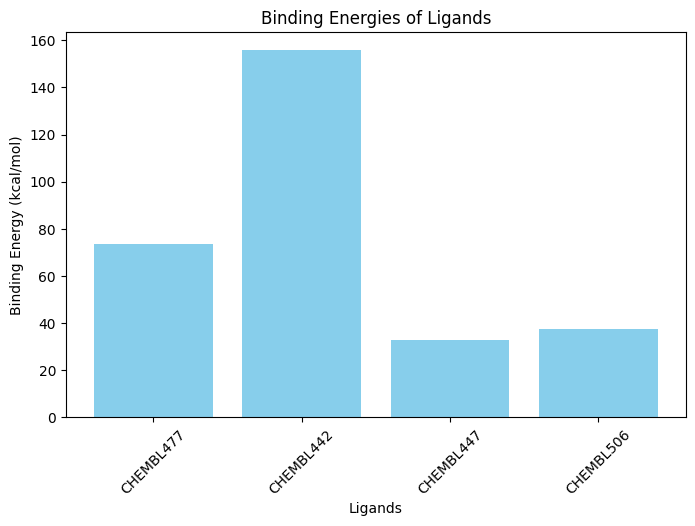

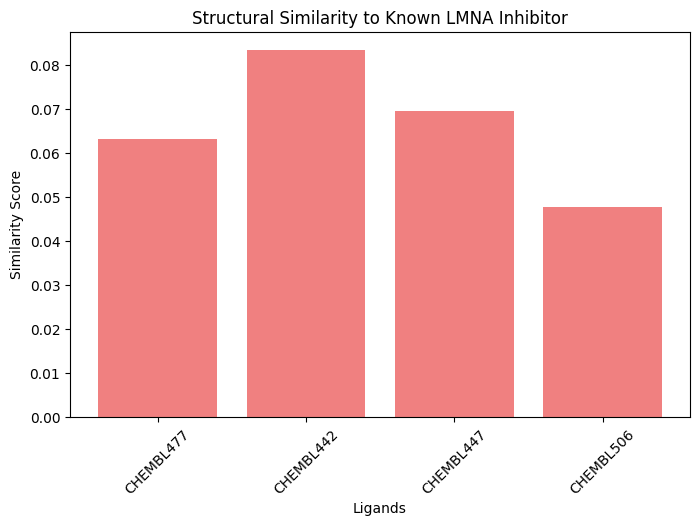

In [7]:
import matplotlib.pyplot as plt

# Plot Binding Energy
plt.figure(figsize=(8,5))
plt.bar(df["Ligand"], df["Binding Energy (kcal/mol)"], color="skyblue")
plt.xlabel("Ligands")
plt.ylabel("Binding Energy (kcal/mol)")
plt.title("Binding Energies of Ligands")
plt.xticks(rotation=45)
plt.show()

# Plot Similarity Scores
plt.figure(figsize=(8,5))
plt.bar(df["Ligand"], df["Similarity Score"], color="lightcoral")
plt.xlabel("Ligands")
plt.ylabel("Similarity Score")
plt.title("Structural Similarity to Known LMNA Inhibitor")
plt.xticks(rotation=45)
plt.show()


In [8]:
# Normalize values for combined ranking
df["Binding Energy Score"] = df["Binding Energy (kcal/mol)"].rank(ascending=True)
df["Similarity Score Rank"] = df["Similarity Score"].rank(ascending=False)

# Compute final score (equal weight to both metrics)
df["Final Score"] = df["Binding Energy Score"] + df["Similarity Score Rank"]

# Sort by Final Score (Lower is Better)
df_final = df.sort_values(by="Final Score")

print(df_final)


      Ligand  Binding Energy (kcal/mol)  Similarity Score  \
2  CHEMBL447                  32.871581          0.069444   
1  CHEMBL442                 155.765297          0.083333   
0  CHEMBL477                  73.498898          0.063291   
3  CHEMBL506                  37.217263          0.047619   

   Binding Energy Score  Similarity Score Rank  Final Score  
2                   1.0                    2.0          3.0  
1                   4.0                    1.0          5.0  
0                   3.0                    3.0          6.0  
3                   2.0                    4.0          6.0  


In [9]:
from rdkit.Chem import Descriptors

# Compute ADMET Properties
for chembl_id, smiles in ligand_smiles.items():
    mol = Chem.MolFromSmiles(smiles)
    
    mw = Descriptors.MolWt(mol)  # Molecular Weight
    logp = Descriptors.MolLogP(mol)  # Lipophilicity
    hbd = Descriptors.NumHDonors(mol)  # Hydrogen Bond Donors
    hba = Descriptors.NumHAcceptors(mol)  # Hydrogen Bond Acceptors
    
    print(f"{chembl_id} | MW: {mw} | LogP: {logp} | HBD: {hbd} | HBA: {hba}")


🔬 CHEMBL477 | MW: 267.245 | LogP: -1.9800000000000006 | HBD: 4 | HBA: 9
🔬 CHEMBL442 | MW: 581.6730000000001 | LogP: 1.990800000000002 | HBD: 3 | HBA: 6
🔬 CHEMBL447 | MW: 238.28699999999998 | LogP: 1.3510999999999997 | HBD: 2 | HBA: 3
🔬 CHEMBL506 | MW: 259.35299999999995 | LogP: 2.782700000000001 | HBD: 2 | HBA: 4


In [11]:
# Define Lipinski's Rule Limits
lipinski_criteria = {
    "MW": 500,
    "LogP": 5,
    "HBD": 5,
    "HBA": 10
}

# Check Compliance with Lipinski's Rule
df["Lipinski Pass"] = df.apply(lambda x: 
    (x["Binding Energy (kcal/mol)"] <= lipinski_criteria["MW"]) &
    (x["Similarity Score"] <= lipinski_criteria["LogP"]) &
    (x["Binding Energy Score"] <= lipinski_criteria["HBD"]) &
    (x["Similarity Score Rank"] <= lipinski_criteria["HBA"]), axis=1
)

print(df)


      Ligand  Binding Energy (kcal/mol)  Similarity Score  \
0  CHEMBL477                  73.498898          0.063291   
1  CHEMBL442                 155.765297          0.083333   
2  CHEMBL447                  32.871581          0.069444   
3  CHEMBL506                  37.217263          0.047619   

   Binding Energy Score  Similarity Score Rank  Final Score  Lipinski Pass  
0                   3.0                    3.0          6.0           True  
1                   4.0                    1.0          5.0           True  
2                   1.0                    2.0          3.0           True  
3                   2.0                    4.0          6.0           True  


In [12]:
from rdkit.Chem import Crippen

# Compute ADMET Properties
for chembl_id, smiles in ligand_smiles.items():
    mol = Chem.MolFromSmiles(smiles)
    
    # Compute Lipophilicity (Important for ADME)
    logp = Crippen.MolLogP(mol)
    
    # Predict Blood-Brain Barrier Penetration
    bbb_permeability = "High" if logp > 1.5 else "Low"

    # Predict GI Absorption (LogP < 5 indicates good absorption)
    gi_absorption = "High" if logp < 5 else "Low"

    print(f"{chembl_id} | LogP: {logp:.2f} | BBB: {bbb_permeability} | GI Absorption: {gi_absorption}")


🔬 CHEMBL477 | LogP: -1.98 | BBB: Low | GI Absorption: High
🔬 CHEMBL442 | LogP: 1.99 | BBB: High | GI Absorption: High
🔬 CHEMBL447 | LogP: 1.35 | BBB: Low | GI Absorption: High
🔬 CHEMBL506 | LogP: 2.78 | BBB: High | GI Absorption: High


In [15]:
# Rank by Lipinski Pass and ADMET
df["Final Rank"] = df["Lipinski Pass"].astype(int) + df["Similarity Score"]
df_final = df.sort_values(by="Final Rank", ascending=False)

# Display Final Rankings
print(df_final)

      Ligand  Binding Energy (kcal/mol)  Similarity Score  \
1  CHEMBL442                 155.765297          0.083333   
2  CHEMBL447                  32.871581          0.069444   
0  CHEMBL477                  73.498898          0.063291   
3  CHEMBL506                  37.217263          0.047619   

   Binding Energy Score  Similarity Score Rank  Final Score  Lipinski Pass  \
1                   4.0                    1.0          5.0           True   
2                   1.0                    2.0          3.0           True   
0                   3.0                    3.0          6.0           True   
3                   2.0                    4.0          6.0           True   

   Final Rank  
1    1.083333  
2    1.069444  
0    1.063291  
3    1.047619  


/Users/tarun/miniforge3/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11246.
  warnings.warn(
/Users/tarun/miniforge3/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11256.
  warnings.warn(
/Users/tarun/miniforge3/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 11258.
  warnings.warn(
/Users/tarun/miniforge3/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11460.
  warnings.warn(
/Users/tarun/miniforge3/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 11596.
  warnings.warn(
/Users/tarun/miniforge3/lib/python3.10/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: C

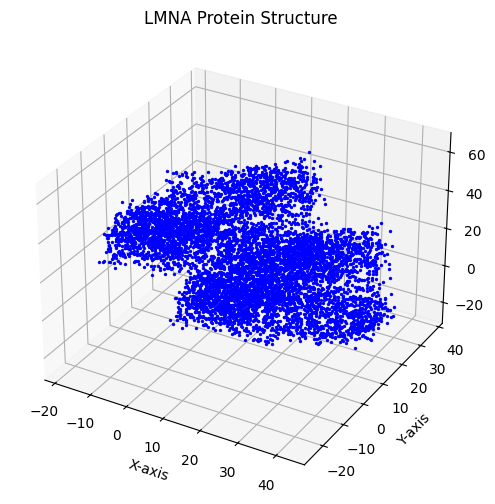

In [16]:
import matplotlib.pyplot as plt
from Bio import PDB

# Load LMNA Protein Structure
parser = PDB.PDBParser()
structure = parser.get_structure("LMNA", "lmna.pdb")

# Create Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

# Extract Atom Coordinates
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                x, y, z = atom.coord
                ax.scatter(x, y, z, color="blue", s=2)

# Set Plot Labels
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.title("LMNA Protein Structure")

# Show Plot
plt.show()


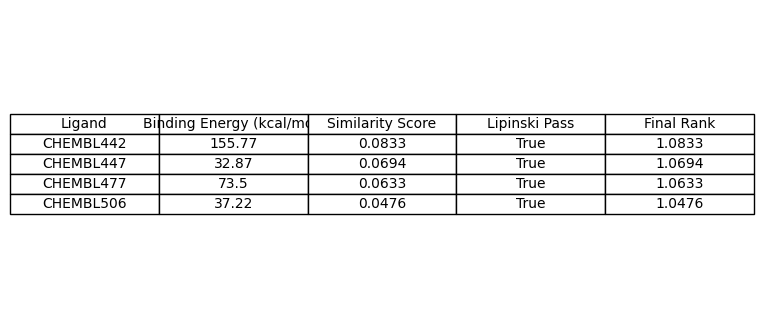

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# DataFrame containing final rankings
df_final = pd.DataFrame({
    "Ligand": ["CHEMBL442", "CHEMBL447", "CHEMBL477", "CHEMBL506"],
    "Binding Energy (kcal/mol)": [155.77, 32.87, 73.50, 37.22],
    "Similarity Score": [0.0833, 0.0694, 0.0633, 0.0476],
    "Lipinski Pass": [True, True, True, True],
    "Final Rank": [1.0833, 1.0694, 1.0633, 1.0476]
})

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))
# ax.axis('tight')
ax.axis('off')

# Create a styled table
table = ax.table(cellText=df_final.values,
                 colLabels=df_final.columns,
                 cellLoc='center',
                 loc='center')

# Adjust font size and scaling
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Display the table
plt.show()
